In [3]:
import numpy as np                     # Packages for Data Analysis
import pandas as pd
import random as rand
from scipy.signal import correlate, correlation_lags

import matplotlib.pyplot as plt       # Packages for making plots
from matplotlib.patches import FancyArrow
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.patches import Patch, Circle
from matplotlib.lines import Line2D
from scipy.ndimage import gaussian_filter1d

import braingeneers                  # Braigneneers packages for analysis
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster
import braingeneers.data.datasets_electrophysiology as ephys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [2]:
sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')

/tmp/ipykernel_38337/653605344.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd = read_phy_files('/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')


In [4]:
def calculate_mean_firing_rates(spike_data):
    # Compute mean firing rates for each neuron
    firing_rates = [len(train) / spike_data.length for train in spike_data.train]
    return firing_rates

def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data[0].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

In [30]:
def precalculate_distances_angles(neuron_positions):
    # Vectorized calculation of distances
    diff = neuron_positions[:, np.newaxis, :] - neuron_positions[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))
    
    # Vectorized calculation of angles
    angles = np.arctan2(diff[..., 1], diff[..., 0]) % (2 * np.pi)
    
    return distances, angles

def calculate_relative_metrics(spike_data, spatial_range, time_window):
    neuron_positions = get_neuron_positions(spike_data)
    distances, angles = precalculate_distances_angles(neuron_positions)
    
    relative_metrics = []

    for neuron_id, spikes in enumerate(spike_data.train):
        if neuron_id % 10 == 0:  # Adjust the modulus value to change the frequency of updates
            print(f"Processing neuron {neuron_id + 1}/{spike_data.N} ({(neuron_id + 1) / spike_data.N * 100:.2f}%)")

        for spike_time in spikes:
            # Identify neurons within the spatial range
            within_range = np.logical_and(distances[neuron_id] >= spatial_range[0], distances[neuron_id] <= spatial_range[1])
            
            # For each other neuron, check if there are spikes within the time window
            for other_id, other_spikes in enumerate(spike_data.train):
                if neuron_id == other_id or not within_range[other_id]:
                    continue
                
                time_diff = np.abs(other_spikes - spike_time)
                valid_spikes = time_diff <= time_window
                
                if valid_spikes.any():
                    valid_distances = distances[neuron_id, other_id]
                    valid_angles = angles[neuron_id, other_id]
                    relative_metrics.append((neuron_id, spike_time, valid_distances, valid_angles))
    
    return relative_metrics

def plot_directional_activity(spike_data, spatial_range, grid_size, time_window):
    relative_metrics = calculate_relative_metrics(spike_data, spatial_range, time_window)
    num_cells = int(np.ceil(spatial_range[1] / grid_size))
    angle_grid = np.zeros((num_cells, num_cells, 3))  # HSV color space
    
    neuron_positions = get_neuron_positions(spike_data)
    cell_positions = np.floor(neuron_positions / grid_size).astype(int)
    
    for neuron_id, spike_time, distances, angles in relative_metrics:
        cell_x, cell_y = cell_positions[neuron_id]
        cell_x = min(cell_x, num_cells - 1)
        cell_y = min(cell_y, num_cells - 1)
        hue = angles / (2 * np.pi)
        angle_grid[cell_y, cell_x] += np.array([hue, 1, 1])  # Saturation and value fixed at 1
    
    # Normalize
    norm = np.linalg.norm(angle_grid, axis=2, keepdims=True)
    norm[norm == 0] = 1
    angle_grid /= norm
    
    rgb_grid = hsv_to_rgb(angle_grid)
    
    plt.imshow(rgb_grid, extent=[0, spatial_range[1], 0, spatial_range[1]])
    plt.title('Directional Activity Map')
    plt.xlabel('X Position (μm)')
    plt.ylabel('Y Position (μm)')
    plt.colorbar(label='Average Direction')
    plt.show()

/tmp/ipykernel_38337/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing neuron 1/140 (0.71%)
Processing neuron 11/140 (7.86%)
Processing neuron 21/140 (15.00%)
Processing neuron 31/140 (22.14%)
Processing neuron 41/140 (29.29%)
Processing neuron 51/140 (36.43%)
Processing neuron 61/140 (43.57%)
Processing neuron 71/140 (50.71%)
Processing neuron 81/140 (57.86%)
Processing neuron 91/140 (65.00%)
Processing neuron 101/140 (72.14%)
Processing neuron 111/140 (79.29%)
Processing neuron 121/140 (86.43%)
Processing neuron 131/140 (93.57%)


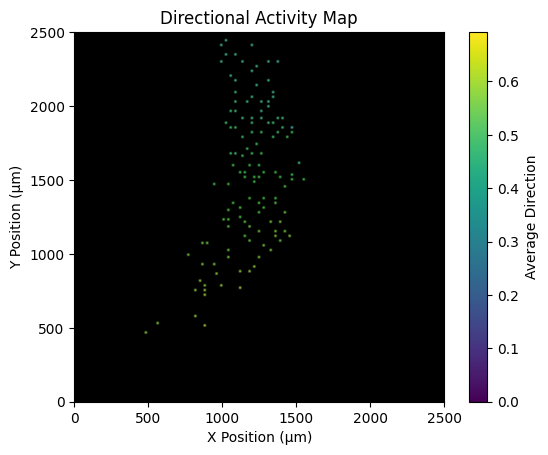

In [15]:
spatial_range = [0, 2500]  # μm
time_window = 20  # Time window for considering coincident spikes
grid_size = 16  # Size

plot_directional_activity(sd, spatial_range, grid_size, time_window)

/tmp/ipykernel_38337/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing neuron 1/140 (0.71%)
Processing neuron 11/140 (7.86%)
Processing neuron 21/140 (15.00%)
Processing neuron 31/140 (22.14%)
Processing neuron 41/140 (29.29%)
Processing neuron 51/140 (36.43%)
Processing neuron 61/140 (43.57%)
Processing neuron 71/140 (50.71%)
Processing neuron 81/140 (57.86%)
Processing neuron 91/140 (65.00%)
Processing neuron 101/140 (72.14%)
Processing neuron 111/140 (79.29%)
Processing neuron 121/140 (86.43%)
Processing neuron 131/140 (93.57%)


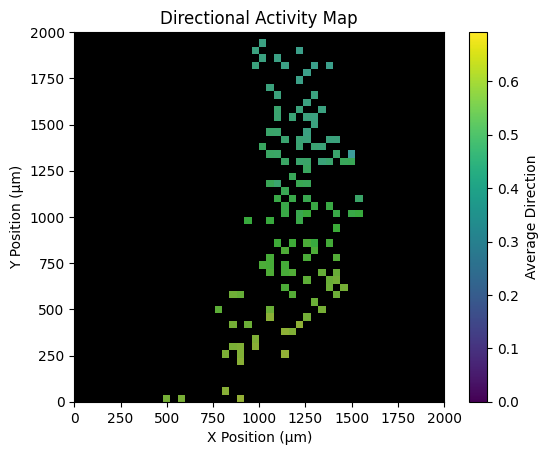

In [25]:
spatial_range = [200, 2000]  # μm
time_window = 20  # Time window for considering coincident spikes
grid_size = 40  # Size
plot_directional_activity(sd, spatial_range, grid_size, time_window)

In [34]:
def calculate_relative_distance_metrics(spike_data, spatial_range, time_window, bins):
    neuron_positions = get_neuron_positions(spike_data)
    distances, _ = precalculate_distances_angles(neuron_positions)
    
    relative_distance_metrics = []

    # Histogram bins for distances
    distance_bins = np.linspace(spatial_range[0], spatial_range[1], bins + 1)

    for neuron_id, spikes in enumerate(spike_data.train):
        for spike_time in spikes:
            # Identify neurons within the spatial range
            within_range = np.logical_and(distances[neuron_id] >= spatial_range[0], distances[neuron_id] <= spatial_range[1])
            
            neuron_distances = []

            for other_id, other_spikes in enumerate(spike_data.train):
                if neuron_id == other_id or not within_range[other_id]:
                    continue
                
                time_diff = np.abs(other_spikes - spike_time)
                valid_spikes = time_diff <= time_window
                
                if valid_spikes.any():
                    valid_distance = distances[neuron_id, other_id]
                    neuron_distances.append(valid_distance)
            
            if neuron_distances:
                # Collect distances in histograms within the defined bins
                hist, _ = np.histogram(neuron_distances, bins=distance_bins)
                relative_distance_metrics.append((neuron_id, spike_time, hist))
    
    return relative_distance_metrics, distance_bins

def plot_distance_activity(spike_data, spatial_range, grid_size, time_window, bins):
    relative_distance_metrics, distance_bins = calculate_relative_distance_metrics(spike_data, spatial_range, time_window, bins)
    num_cells = int(np.ceil(spatial_range[1] / grid_size))
    
    distance_grid = np.zeros((num_cells, num_cells, bins))  # For distance histograms
    
    neuron_positions = get_neuron_positions(spike_data)
    cell_positions = np.floor(neuron_positions / grid_size).astype(int)
    
    for neuron_id, spike_time, distance_hist in relative_distance_metrics:
        cell_x, cell_y = cell_positions[neuron_id]
        cell_x = min(cell_x, num_cells - 1)
        cell_y = min(cell_y, num_cells - 1)
        distance_grid[cell_y, cell_x] += distance_hist
    
    # Normalize
    norm = np.linalg.norm(distance_grid, axis=2, keepdims=True)
    norm[norm == 0] = 1
    distance_grid /= norm
    
    # Plotting
    plt.figure(figsize=(10, 8))
    for i in range(bins):
        plt.subplot(2, 3, i + 1)
        plt.imshow(distance_grid[:, :, i], extent=[0, spatial_range[1], 0, spatial_range[1]])
        plt.title(f'Distance Bin {distance_bins[i]:.2f}-{distance_bins[i+1]:.2f} μm')
        plt.xlabel('X Position (μm)')
        plt.ylabel('Y Position (μm)')
    
    plt.tight_layout()
    plt.show()

In [38]:
plot_distance_activity(sd, spatial_range, grid_size, time_window, 10)

/tmp/ipykernel_38337/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


KeyboardInterrupt: 

/tmp/ipykernel_38337/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


ValueError: num must be an integer with 1 <= num <= 6, not 7

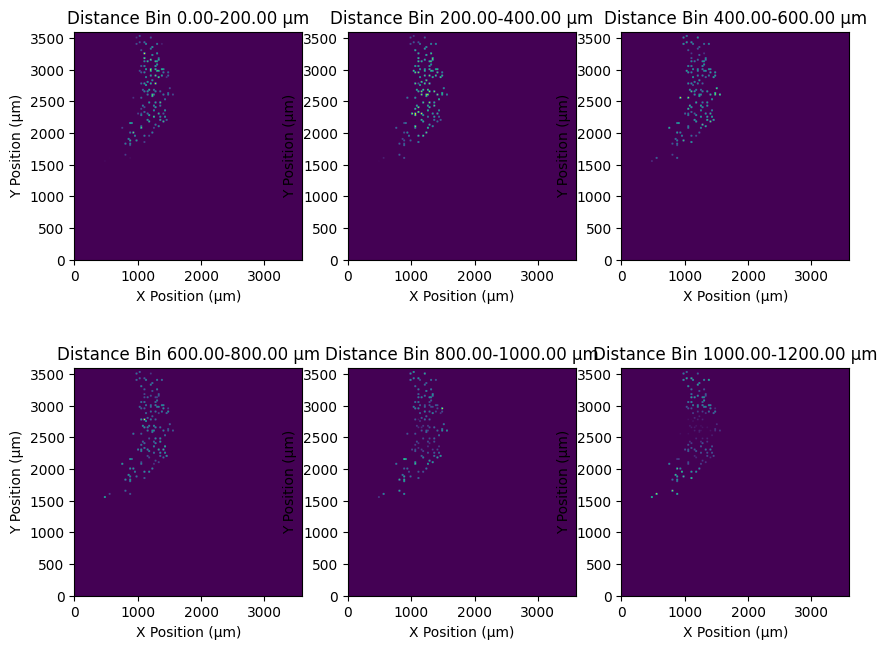

In [39]:
plot_distance_activity(sd, spatial_range, grid_size, time_window, 18)

In [31]:
plot_distance_activity(sd, spatial_range, grid_size, time_window, 6)

TypeError: calculate_relative_metrics() takes 3 positional arguments but 4 were given

In [28]:
def plot_directional_activity_with_color_wheel(spike_data, spatial_range, grid_size, time_window):
    relative_metrics = calculate_relative_metrics(spike_data, spatial_range, time_window)
    num_cells = int(np.ceil(spatial_range[1] / grid_size))
    angle_grid = np.zeros((num_cells, num_cells, 3))  # HSV color space

    neuron_positions = get_neuron_positions(spike_data)
    cell_positions = np.floor(neuron_positions / grid_size).astype(int)

    for neuron_id, spike_time, distances, angles in relative_metrics:
        cell_x, cell_y = cell_positions[neuron_id]
        cell_x = min(cell_x, num_cells - 1)
        cell_y = min(cell_y, num_cells - 1)
        hue = angles / (2 * np.pi)
        angle_grid[cell_y, cell_x] += np.array([hue, 1, 1])  # Saturation and value fixed at 1

    # Normalize by the number of contributions to each cell to maintain distinct hues
    hue_counts = np.sum(angle_grid[:, :, 1], axis=1, keepdims=True)
    hue_counts[hue_counts == 0] = 1  # Avoid division by zero
    angle_grid[:, :, 0] /= hue_counts[:, :, 0]  # Normalize hue by count

    # Convert HSV to RGB for display
    rgb_grid = hsv_to_rgb(angle_grid)

    # Create the main figure and axis for the directional activity map
    fig, ax = plt.subplots()
    im = ax.imshow(rgb_grid, extent=[0, spatial_range[1], 0, spatial_range[1]])

    # Title and labels
    ax.set_title('Directional Activity Map')
    ax.set_xlabel('X Position (μm)')
    ax.set_ylabel('Y Position (μm)')

    # Draw a color wheel as an inset
    ax_inset = fig.add_axes([0.8, 0.1, 0.15, 0.15], polar=True)
    col = np.linspace(0, 1, 256)
    rad = np.linspace(0, 2*np.pi, 256)
    r, theta = np.meshgrid(col, rad)
    rgb = hsv_to_rgb(np.dstack((theta / (2 * np.pi), r, np.ones_like(r))))
    ax_inset.imshow(rgb, extent=(0, 2*np.pi, 0, 1), aspect='auto', transform=ax_inset.transData._b)

    # Hide polar labels
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.set_title('Color Wheel')

    plt.show()

In [29]:
spatial_range = [0, 3600]  # μm
time_window = 25  # Time window for considering coincident spikes
grid_size = 25  # Size
plot_directional_activity_with_color_wheel(sd, spatial_range, grid_size, time_window)

/tmp/ipykernel_38337/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing neuron 1/140 (0.71%)
Processing neuron 11/140 (7.86%)
Processing neuron 21/140 (15.00%)
Processing neuron 31/140 (22.14%)
Processing neuron 41/140 (29.29%)
Processing neuron 51/140 (36.43%)
Processing neuron 61/140 (43.57%)
Processing neuron 71/140 (50.71%)
Processing neuron 81/140 (57.86%)
Processing neuron 91/140 (65.00%)
Processing neuron 101/140 (72.14%)
Processing neuron 111/140 (79.29%)
Processing neuron 121/140 (86.43%)
Processing neuron 131/140 (93.57%)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [19]:
def plot_directional_activity2(spike_data, spatial_range, grid_size, time_window):
    relative_metrics = calculate_relative_metrics(spike_data, spatial_range, time_window)
    num_cells = int(np.ceil(spatial_range[1] / grid_size))
    
    # Initialize HSV grid: Hue for direction, Saturation for magnitude, Value for activity presence
    hsv_grid = np.zeros((num_cells, num_cells, 3))
    
    neuron_positions = get_neuron_positions(spike_data)
    cell_positions = np.floor(neuron_positions / grid_size).astype(int)
    
    for neuron_id, spike_time, distances, angles in relative_metrics:
        cell_x, cell_y = cell_positions[neuron_id]
        
        # Ensure that the indices are within the bounds of the grid
        cell_x = min(cell_x, num_cells - 1)
        cell_y = min(cell_y, num_cells - 1)
        
        # Hue based on angle, full saturation, and value based on distance (or some other metric)
        hue = angles / (2 * np.pi)
        saturation = np.ones_like(hue)  # Full saturation
        value = np.ones_like(hue)  # Adjust this if you want to represent magnitude
        
        if np.isscalar(angles):
            angles = [angles]
            hue = [hue]
            saturation = [saturation]
            value = [value]

        # Accumulate the HSV values
        for i, angle in enumerate(angles):
            hsv_grid[cell_y, cell_x] += np.array([hue[i], saturation[i], value[i]])
    
    # Normalize the saturation and value channels to prevent overflow
    hsv_grid[:, :, 1:] = hsv_grid[:, :, 1:] / np.max(hsv_grid[:, :, 1:], axis=(0, 1))

    rgb_grid = hsv_to_rgb(hsv_grid)
    
    plt.imshow(rgb_grid, extent=[0, spatial_range[1], 0, spatial_range[1]])
    plt.title('Directional Activity Map')
    plt.xlabel('X Position (μm)')
    plt.ylabel('Y Position (μm)')
    plt.colorbar(label='Average Direction')
    plt.show()

/tmp/ipykernel_38337/2495652857.py:10: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data[0].values():


Processing neuron 1/140 (0.71%)
Processing neuron 11/140 (7.86%)
Processing neuron 21/140 (15.00%)
Processing neuron 31/140 (22.14%)
Processing neuron 41/140 (29.29%)
Processing neuron 51/140 (36.43%)
Processing neuron 61/140 (43.57%)
Processing neuron 71/140 (50.71%)
Processing neuron 81/140 (57.86%)
Processing neuron 91/140 (65.00%)
Processing neuron 101/140 (72.14%)
Processing neuron 111/140 (79.29%)
Processing neuron 121/140 (86.43%)
Processing neuron 131/140 (93.57%)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


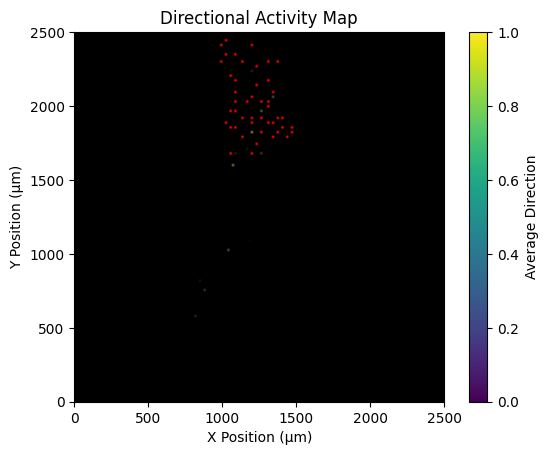

In [20]:
spatial_range = [0, 2500]  # μm
time_window = 20  # Time window for considering coincident spikes
grid_size = 16  # Size

plot_directional_activity2(sd, spatial_range, grid_size, time_window)